## 2D lattice 그리기

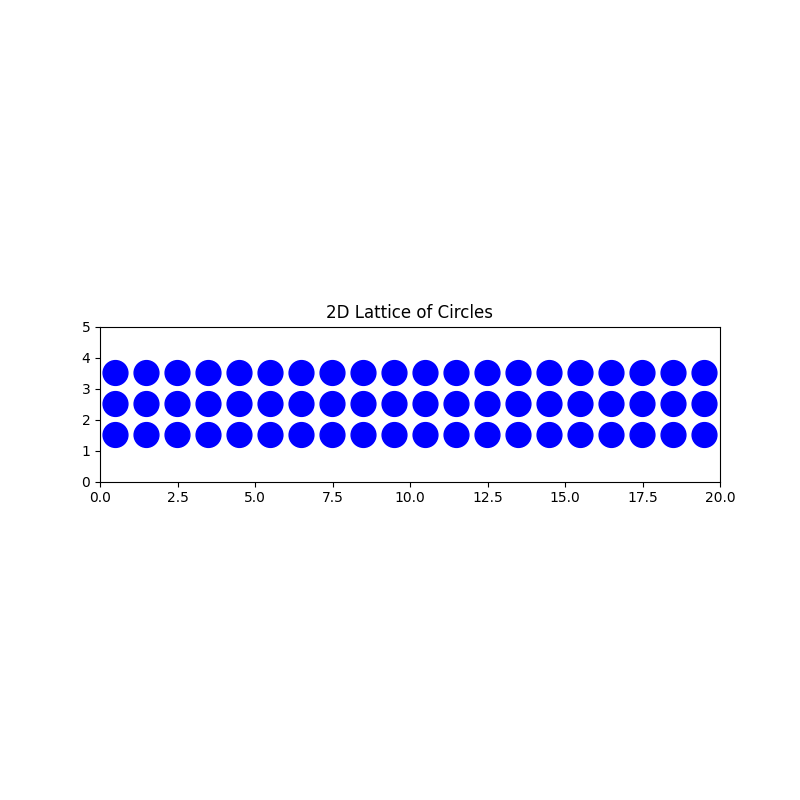

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
width = 20  # Size of the square lattice (N x N)
height = 5
atom_radius = 0.4  # Radius of the atom circles

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(8, 8))

# Function to initialize the lattice
def init_lattice(width, height):
    lattice = np.ones((height, width), dtype=int)
    return lattice

# Function to plot the lattice of circles
def plot_lattice(lattice, atom_radius):
    for x in range(width):
        for y in range(height):
            if lattice[y, x] == 1:
                circle = plt.Circle((x + 0.5, y + 0.5), atom_radius, color='blue')
                ax.add_artist(circle)

# Initialize the lattice
lattice = init_lattice(width, height)
lattice[0, :] = 0
lattice[-1, :] = 0
# Mark specific lattice sites as occupied (atoms)
# For example, mark the center and corners as occupied:
# lattice[N // 2, N // 2] = 1
# lattice[0, 0] = 1
# lattice[0, N - 1] = 1
# lattice[N - 1, 0] = 1
# lattice[N - 1, N - 1] = 1

# Plot the lattice of circles
plot_lattice(lattice, atom_radius)

# Set the axis limits and display the plot
ax.set_xlim(0, width)
ax.set_ylim(0, height)
ax.set_aspect('equal')  # Ensure equal aspect ratio for circles

plt.title("2D Lattice of Circles")
plt.show()


## 2D lattice 그리고 diffusion까지

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib ipympl

# Parameters
width = 100  # Size of the square lattice (height x width)
height = 5
n_vacancies = 10  # Number of vacancies
surface_jump_rate = 0.1  # Diffusion rate
atom_radius = 0.4

# Initialize the lattice
lattice = np.zeros((height+2, width), dtype=int)

# Randomly place vacancies in the lattice
for _ in range(n_vacancies):
    x = np.random.randint(0, height)
    y = np.random.randint(0, width)
    lattice[x, y] = 1

# Function to perform vacancy diffusion
def diffuse_vacancies(lattice, surface_jump_rate):
    new_lattice = lattice.copy()
    for x in range(height):
        for y in range(width):
            if lattice[x, y] == 1:
                # Randomly choose a neighboring site
                dx, dy = np.random.choice([-1, 0, 1], 2)
                new_x, new_y = (x + dx) % height, (y + dy) % width
                # Check if the neighboring site is empty
                if lattice[new_x, new_y] == 0:
                    # Move the vacancy to the neighboring site
                    new_lattice[x, y] = 0
                    new_lattice[new_x, new_y] = 1
    return new_lattice

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Function to update the lattice in the animation
def update(frame):
    ax.clear()
    draw_lattice()
    ax.set_title(f"Time step {frame}")
    lattice[:] = diffuse_vacancies(lattice, surface_jump_rate)

# # Create the animation
ani = animation.FuncAnimation(fig, update, frames=100, interval=200, blit=False)
ani.save('atom_diffusion_animation.gif', writer='pillow', fps=10)
def draw_lattice():
    for x in range(width):
        for y in range(height):
            if lattice[y, x] == 0:
                    circle = plt.Circle((x + 0.5, y + 0.5), atom_radius, color='blue')
                    ax.add_artist(circle)
    ax.set_xlim(0, width)
    ax.set_ylim(0, height+2)
    ax.axis('off')
    ax.set_aspect('equal')
# draw_lattice()

(5, 20)

### 하나씩 차근차근 해보아요

#### 1. setting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib ipympl

In [2]:
# Parameters
width = 100  # Size of the square lattice (height x width)
height = 10

surface_jump_rate = 0.1     # bond 3 -> 0
return_rate = 10            # bond 0 -> 3
surface_diffusion_rate = 3  # bond 2 -> 3

atom_radius = 0.4
steps = 10
t = 0

In [3]:
# function to initialize the lattice
'''
Initialize the lattice
1 : atom
0 : vacancy or vacumm
'''
def init_lattice(width, height):
    lattice = np.ones((height+2, width), dtype=int)
    lattice[0, :] = 0
    lattice[-1, :] = 0

    return lattice

In [4]:
# Function to plot the lattice of circles
def plot_lattice(ax, width, height, atom_radius, lattice):
    for x in range(width):
        for y in range(height+2):
            if lattice[y, x] == 1:
                circle = plt.Circle((x + 0.5, y + 0.5), atom_radius, color='blue')
                ax.add_artist(circle)
    ax.set_xlim(0, width)
    ax.set_ylim(0, height+2)
    ax.set_aspect('equal')
    ax.axis('off')
    plt.tight_layout(pad=0.5)

In [5]:
'''
function that finds every possible way
current state
1. atom jump at surface
2. return to previous position(jumped from surface)
3. atom jump from side
'''
def find_candidate(lattice):
    candidate_table = []
    diffusion_table = []
    motion_table = []
    for x in range(width):
        for y in range(height+2):
            # find atom(value 1)
            if lattice[y, x] == 1:
                # calculate bond number
                if y == height+1:
                    down = 0
                else:
                    down = lattice[y+1, x]
                if y == 0:
                    up = 0
                else:
                    up = lattice[y-1, x]
                # PBC at left and right
                right = lattice[y, (x+1)//width]
                left = lattice[y, (x-1)//width]
                bond_num = down + up + right + left

                # classify the atoms by bond_num
                # 0 bond num : jumped atom from surface
                if bond_num == 0:
                    candidate_table.append((y, x))
                    diffusion_table.append(return_rate)
                    if y == height+1 :
                        motion_table.append(2)
                    else :
                        motion_table.append(4)
                # 2 bond num : surface atom next to vacancy
                elif bond_num == 2:
                    candidate_table.append((y, x))
                    diffusion_table.append(surface_diffusion_rate)
                    if left == 0 :
                        motion_table.append(1)
                    else:
                        motion_table.append(3)
                # 3 bond num
                # 3-1. surface atom
                elif bond_num == 3:
                    candidate_table.append((y, x))
                    diffusion_table.append(surface_jump_rate)
                    if left == 0 :
                        motion_table.append(1)
                    elif up == 0 :
                        motion_table.append(2)
                    elif right == 0 :
                        motion_table.append(3)
                    else:
                        motion_table.append(4)
                
    
    return candidate_table, diffusion_table, motion_table

In [6]:
# KMC function
def diffuse_one_step(lattice):
    cand, dif, motion = find_candidate(lattice)
    dif = np.array(dif)

    total_dif = np.sum(dif)
    

    # pick 1
    u = np.random.uniform(low=1e-6, high=1)
    cum_dif = np.cumsum(dif)

    chosen_idx = np.argwhere(u*total_dif < cum_dif)[0][0]

    # print information
    # print(f'total_diff : {total_dif}')
    # print(f'chosen_idx : {cand[chosen_idx]}')
    # print(f'motion : {motion[chosen_idx]}')
    # print(cand[chosen_idx])
    # print(motion[chosen_idx])

    # change the lattice
    x, y = cand[chosen_idx][0], cand[chosen_idx][1]

    # get motion
    if motion[chosen_idx] == 1:
        lattice[x, y] = 0
        lattice[x, (y-1+width)//width] = 1
    if motion[chosen_idx] == 2:
        lattice[x, y] = 0
        lattice[x-1 , y] = 1
    if motion[chosen_idx] == 3:
        lattice[x, y] = 0
        lattice[x, (y+1)//width] = 1
    if motion[chosen_idx] == 4:
        lattice[x, y] = 0
        lattice[x+1 , y] = 1
    

In [18]:
lattice = init_lattice(width, height)

In [19]:
'''
just kmc implement!
'''
# lattice = init_lattice(width, height)
# for i in range(1, steps+1):
#     print(f'---------------- step {i} ---------------------')
#     diffuse_one_step(lattice)
#     fig, ax = plt.subplots(figsize=(10, 2))
#     plot_lattice(ax, width, height, atom_radius, lattice)

'\njust kmc implement!\n'

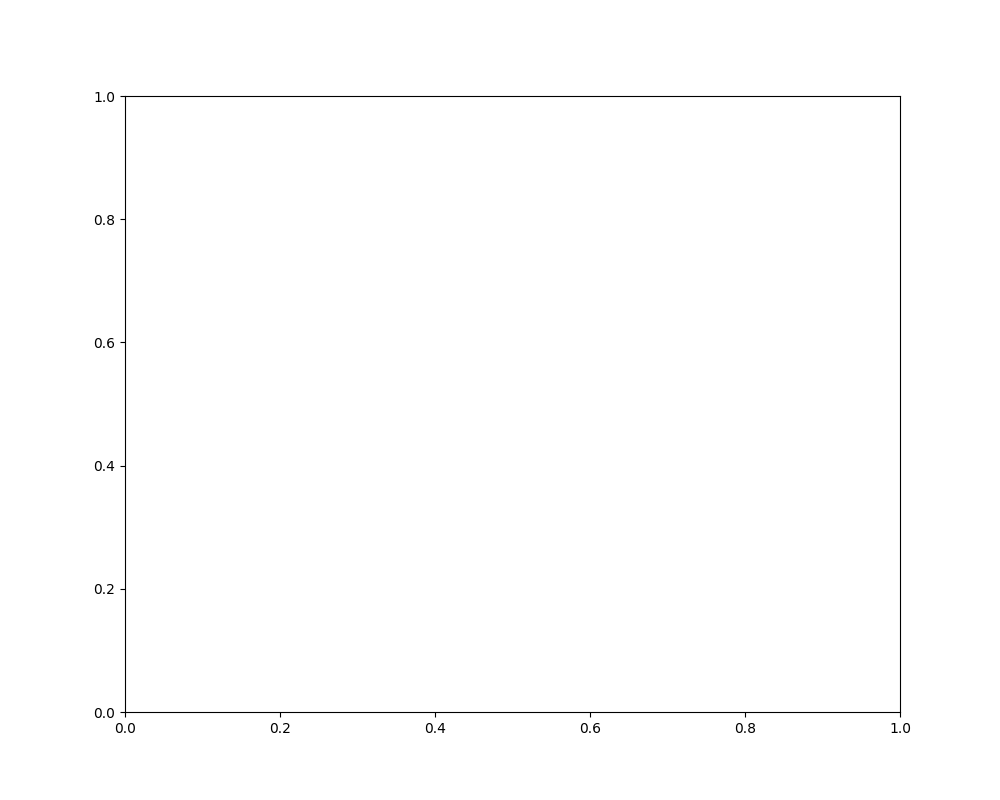

In [21]:
# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(10, 8))

# initialize lattice
lattice = init_lattice(width, height)

# Function to update the lattice in the animation
def update(frame):
    ax.clear()
    plot_lattice(ax, width, height, atom_radius, lattice)
    ax.set_title(f"Time step {frame}")
    diffuse_one_step(lattice)

# # Create the animation
ani = animation.FuncAnimation(fig, update, frames = 500, interval=500, blit=False)
ani.frame_seq = ani.new_frame_seq() 
# ani.save('test.gif', writer='pillow', fps=10)
plt.show()